In this project we will be developing four different trading strategies and testing them against a simple buy and hold strategy. We will decide whether a strategy is valuable based on the multiple metric. The multiple just shows how much money you would make at the end of the period if you invested one dollar at the start of the period. If strategy's multiple is greater than the buy and hold multiple in both backward and forward tests, we consider this strategy valuable. Afterwards, we will compare all valuable strategies between each other.

Our first attempt will be to develop a strategy based on price and and volume changes. Usually, when prices rise to rapidly, they fall afterwards. Likewise, when prices fall rapidly, they usually rise afterwards. Thus, we will check if this is the case with Bitcoin and try to use this to our advantage

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")

### Read Data  
To see how we got bitcoin prices, check the "Get historical data" file

In [131]:
data = pd.read_csv("bitcoin.csv", parse_dates = ["Date"], index_col = "Date")[["Close", "Volume"]]
data

,Close,Volume
Date,,
2017-08-17,4285.08,795.150377
2017-08-18,4108.37,1199.888264
2017-08-19,4139.98,381.309763
2017-08-20,4086.29,467.083022
2017-08-21,4016.00,691.743060
...,...,...
2021-12-27,50701.44,28779.582120
2021-12-28,47543.74,45853.339240
2021-12-29,46464.66,39498.870000


### Visual Inspection

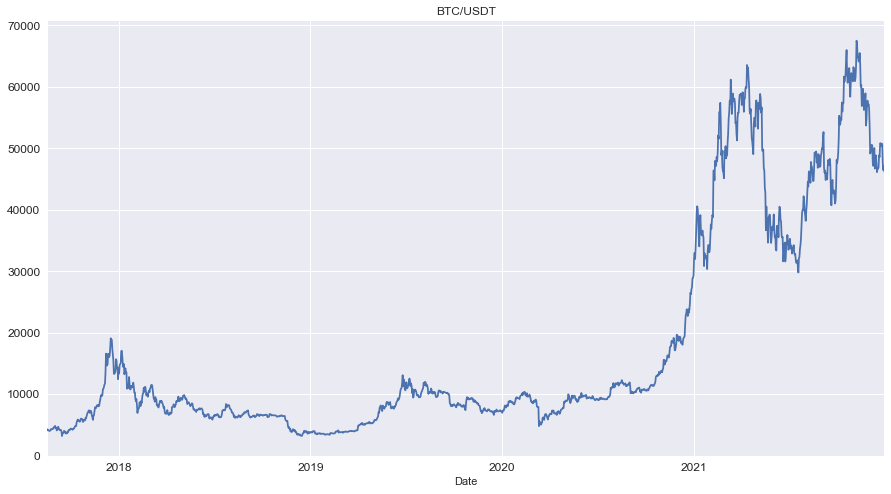

In [132]:
data.Close.plot(figsize = (15, 8), title = "BTC/USDT", fontsize = 12)
plt.show()

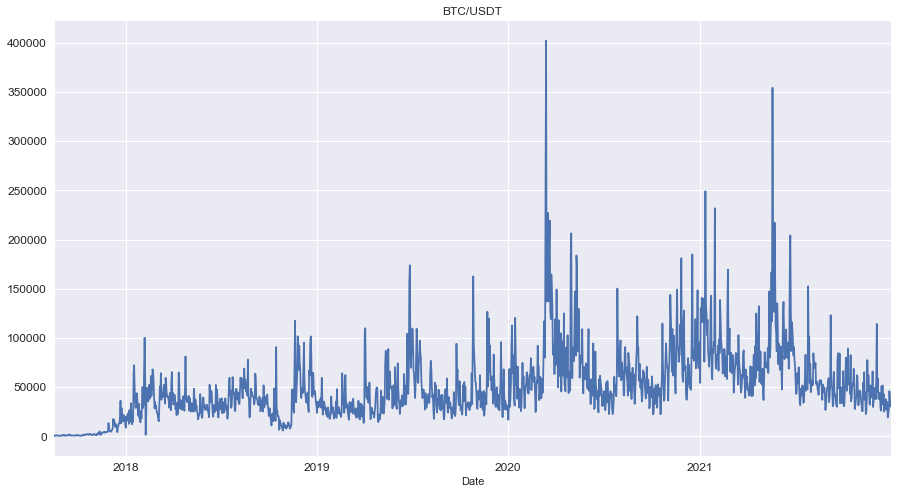

In [133]:
data.Volume.plot(figsize = (15, 8), title = "BTC/USDT", fontsize = 12)
plt.show()

### Add columns with log returns, log cumulative returns and log vol changes
To see why we decided to stick with log returns and changes, you can read this article:  
https://investmentcache.com/magic-of-log-returns-concept-part-1/  
Simply put, log returns can be added across time periods, they also follow normal distribution and they can be easily converted back to normal returns

In [134]:
data["returns"] = np.log(data.Close.div(data.Close.shift(1)))
data["creturns"] = data.returns.cumsum().apply(np.exp)
data["vol_ch"] = np.log(data.Volume.div(data.Volume.shift(1)))
data.describe()

,Close,Volume,returns,creturns,vol_ch
count,1598.000000,1598.000000,1597.000000,1597.000000,1597.000000
mean,17428.767829,50365.052171,0.001489,4.069235,0.002369
std,17283.607869,36344.363764,0.042917,4.033971,0.393933
min,3189.020000,228.108068,-0.502607,0.744215,-3.687514
25%,6734.915000,28560.245272,-0.015982,1.572283,-0.240131
50%,9288.930000,43473.899234,0.001791,2.167876,-0.022228
75%,18623.210000,64634.678766,0.020168,4.352432,0.245860
max,67525.830000,402201.673764,0.202952,15.758359,2.599870


### Remove outliers from our data

In [135]:
data.vol_ch.nsmallest(20)

Date
2018-02-08   -3.687514
2018-10-16   -1.191795
2019-04-27   -1.154176
2017-08-19   -1.146372
2018-10-21   -1.082867
2020-03-14   -1.077629
2017-12-23   -1.009857
2021-01-30   -1.004639
2017-08-26   -0.922135
2019-11-23   -0.920077
2021-12-05   -0.918494
2021-09-25   -0.917802
2019-05-18   -0.873444
2021-04-24   -0.870664
2019-10-12   -0.859544
2020-06-03   -0.856961
2021-10-16   -0.844327
2020-12-18   -0.842127
2020-04-17   -0.837069
2020-04-11   -0.833797
Name: vol_ch, dtype: float64

In [136]:
data.vol_ch.nlargest(20)

Date
2018-02-09    2.599870
2018-10-15    1.759060
2018-01-16    1.464899
2019-04-02    1.418652
2020-04-29    1.377269
2018-11-14    1.371700
2020-01-14    1.351685
2020-03-12    1.185149
2021-07-26    1.158721
2018-10-11    1.152173
2021-05-19    1.108276
2018-11-19    1.085185
2019-09-24    1.079600
2020-06-15    1.052556
2019-10-25    1.020274
2017-11-29    0.998965
2018-12-17    0.997214
2018-06-10    0.995630
2018-04-12    0.994291
2021-09-20    0.960662
Name: vol_ch, dtype: float64

As we see, a log voulme change bigger or less than 3 is an extreme change. Hence, let's replace entries which have log volume changes greater or less than 3 with NaNs

In [137]:
data.loc[data.vol_ch > 3, "vol_ch"] = np.nan
data.loc[data.vol_ch < -3, "vol_ch"] = np.nan

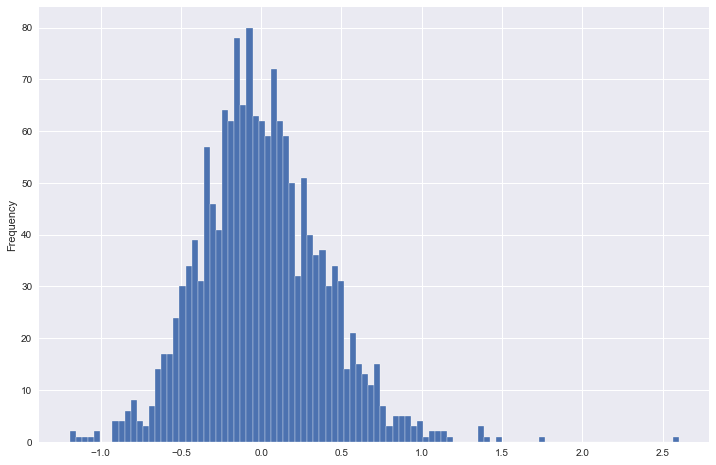

In [138]:
data.vol_ch.plot(kind = "hist", bins = 100, figsize = (12,8))
plt.show()

### Now let's perform some inspection to see whether there is a correlation between price, price changes and volume changes  
In other words, let's check whether our initial hypothesis is true

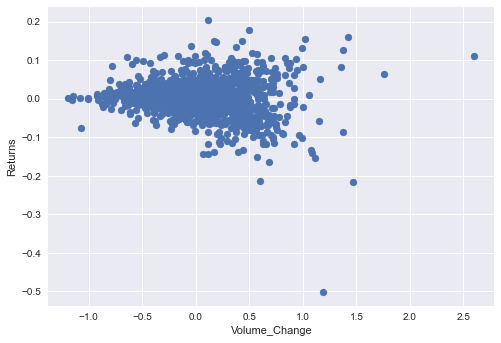

In [139]:
plt.scatter(x = data.vol_ch, y = data.returns)
plt.xlabel("Volume_Change")
plt.ylabel("Returns")
plt.show()

From this plot it is difficult to see whether there is a correlation between prices, returns and volume changes. Hence, for easier analysis let's discretize returns and volume changes into categories from -5 to 5 and plot a heatmap

In [140]:
data["ret_cat"] = pd.qcut(data.returns, q = 10, labels = [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])
data["vol_cat"] = pd.qcut(data.vol_ch, q = 10, labels = [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])
matrix = pd.crosstab(data.vol_cat.shift(), data.ret_cat.shift(),
                     values = data.returns, aggfunc = np.mean)
matrix

ret_cat,-5,-4,-3,-2,-1,1,2,3,4,5
vol_cat,,,,,,,,,,
-5,0.043636,0.014321,0.011371,0.014346,0.009930,0.002410,0.001675,0.005444,-0.008115,-0.019744
-4,-0.004196,-0.004802,-0.010046,0.015530,0.009739,0.001271,0.003273,-0.000157,0.003536,0.008894
-3,0.013032,-0.013186,0.001943,0.002494,-0.000484,-0.014248,0.006954,0.004003,-0.003206,0.031107
-2,0.000381,0.019347,-0.016238,0.009242,-0.007600,-0.002664,-0.009698,0.011213,-0.022539,-0.018691
-1,0.014763,-0.009416,-0.002887,-0.004713,-0.000388,-0.037067,0.006635,-0.001193,-0.004267,0.009189
1,-0.012800,0.007545,0.000429,0.006055,-0.000563,-0.008611,-0.001647,-0.005795,0.004053,0.007156
2,-0.000408,0.018592,-0.012101,0.003444,-0.017989,-0.006959,0.004096,0.007216,0.001901,-0.017981
3,0.006243,0.014438,0.003888,-0.000360,0.000111,0.008250,0.026000,0.019662,-0.006030,0.011568
4,-0.003040,-0.006409,0.008119,0.015609,0.006390,0.022509,-0.018298,-0.002946,0.002897,0.005833


In [141]:
import seaborn as sns

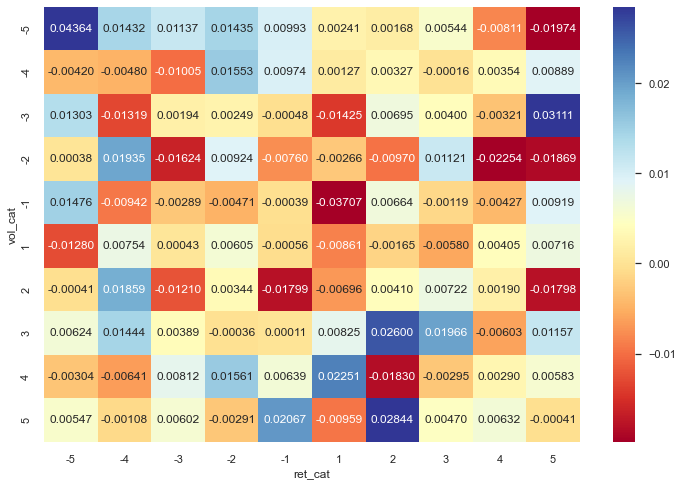

In [142]:
plt.figure(figsize=(12, 8))
sns.set(font_scale=1)
sns.heatmap(matrix, cmap = "RdYlBu", annot = True, robust = True, fmt = ".5f")
plt.show()

As we see on this plot, the day after very high returns and very low volume changes, the returns are highly negative, which means prices usually fall. On the other hand, when the returns are very low and volume changes are also low, the returns next day are highly positive, which means that price will rise. Thus we see this pattern:                                          
- Extremely High (positive) returns and Decreases in Volume is a Contrarian (mean-reverting) signal -> prices will fall.        
- Extremely Low (negative) returns and Decreases in Volume is a Contrarian (mean-reverting) signal -> prices will rise.

## Now let's create a backtester class and test whether our hypothesis is true

Our class will run a backtest on historical data, optimize the parameters, and calculate basic performance metrics like the multiple, CAGR, annualized mean, annualized standard deviation, and Sharpe's ratio as an approximation metric of how risky our strategy is. Our backtester would also include the trading commission in its calculation and we will take it as 0.75%, as this is a typical commission rate for Binance users that hold any amount of binance coin on their account.  

This backtest will serve as a template for all strategies. We will only need to change some strategy-specific functionality. But the majority of the class functionality will stay the same throughout all strategies.  

We can also use this class for forward testing. We will just have to specify the period when initializing this tester

We will use long only strategy in this example, as it outperforms the long_and_short strategy. However, if you want to see how the long_and_short strategy is implemented and how it performed, you can check the Price&VolumeLongShortBot.ipynb file. The difference between these two strategies is described below:  
Long only strategy:  
- Buy BTC/USDT in the spot market and hold it (position 1)
- When there is a signal that prices will fall -> sell BTC (take a neutral position) (position 0)
- When the signal that prices will fall disappears, buy BTC/UDST back  
  
A short position is best understood in the following example. An investor believes that prices of Bitcoin will definitely fall. Thus, he borrows 1 BTC (Bitcoin), immediately sells it for USDTs (US dollar Tether), then the prices indeed fall, he buys back 1 BTC with fewer USDTs than he sold it for, returns back 1 BTC to the lender and keeps the difference in price to himself. Thus, borrowing and immediately selling a an example of taking a short position. Of course, the prices can rise instead of falling and the investor would lose money in this case, if he took a short position.
  
Long and short strategy:  
- Buy BTC/USDT in the spot market and hold it
- When there is a signal that prices will fall -> take a short position (position -1)
- When there is a signal that prices will rise -> buy BTC (take a long position) (position 1)
- When there is no signal -> don't hold any BTC (position 0)

In [76]:
from itertools import product

In [77]:
class Long_Only_Backtester():
    ''' Class for the vectorized backtesting of simple Long-only trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum).
         
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.Close.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "Long_Only_Backtester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["Date"], index_col = "Date")
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        self.data = raw
        
    def test_strategy(self, percentiles = None, thresh = None):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        percentiles: tuple (return_perc, vol_low_perc, vol_high_perc)
            return and volume percentiles to be considered for the strategy.
            
        thresh: tuple (return_thresh, vol_low_thresh, vol_high_thesh)
            return and volume thresholds to be considered for the strategy.
        '''
        
        self.prepare_data(percentiles = percentiles, thresh = thresh)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, percentiles, thresh):
        ''' Prepares the Data for Backtesting.
        '''
        
        data = self.data[["Close", "Volume", "returns"]].copy()
        data["vol_ch"] = np.log(data.Volume.div(data.Volume.shift(1)))
        data.loc[data.vol_ch > 3, "vol_ch"] = np.nan
        data.loc[data.vol_ch < -3, "vol_ch"] = np.nan        
        
        if percentiles:
            self.return_thresh = np.percentile(data.returns.dropna(), percentiles[0])
            self.volume_thresh = np.percentile(data.vol_ch.dropna(), [percentiles[1], percentiles[2]])
        elif thresh:
            self.return_thresh = thresh[0]
            self.volume_thresh = [thresh[1], thresh[2]]
                
        cond1 = data.returns >= self.return_thresh
        cond2 = data.vol_ch.between(self.volume_thresh[0], self.volume_thresh[1])
        
        data["position"] = 1
        data.loc[cond1 & cond2, "position"] = 0

        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | TC = {}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            plt.legend(["Buy and Hold multiple", "Strategy multiple"])
            
    def optimize_strategy(self, return_range, vol_low_range, vol_high_range, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        return_range: tuple
            tuples of the form (start, end, step size).
            
        vol_low_range: tuple
            tuples of the form (start, end, step size).
        
        vol_high_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be "Multiple" or "Sharpe")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        
        return_range = range(*return_range)
        vol_low_range = range(*vol_low_range)
        vol_high_range = range(*vol_high_range)
        
        combinations = list(product(return_range, vol_low_range, vol_high_range))
        
        performance = []
        for comb in combinations:
            self.prepare_data(percentiles = comb, thresh = None)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["returns", "vol_low", "vol_high"])
        self.results_overview["performance"] = performance
        self.find_best_strategy()
        
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum).
        '''
        
        best = self.results_overview.nlargest(1, "performance")
        return_perc = best.returns.iloc[0]
        vol_perc = [best.vol_low.iloc[0], best.vol_high.iloc[0]]
        perf = best.performance.iloc[0]
        print("Return_Perc: {} | Volume_Perc: {} | {}: {}".format(return_perc, vol_perc, self.metric, round(perf, 5))) 
        self.test_strategy(percentiles = (return_perc, vol_perc[0], vol_perc[1]))
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
       
        print(100 * "=")
        print("SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = {} | THRESHOLDS = {}, {}".format(self.symbol, np.round(self.return_thresh, 5), np.round(self.volume_thresh, 5)))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return self.calculate_cagr(series) / self.calculate_annualized_std(series)

Now we have to choose a period for backtesting and forward testing. We have data from 2017-08-17 to 2021-12-31, which is 1597 days. We will leave 25% of the data for forward testing (which is approximately 400 days) and 75% of the data for backward testing (which is approximately 1197 days). Thus, the backtest period will be from 2017-08-17 to 2020-11-25 and the forward test period will be from 2020-11-26 to 2021-12-31

In [119]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2017-08-17"
end = "2020-11-25"
# Trading fees
tc = -0.00075

In [120]:
tester = Long_Only_Backtester(filepath = filepath, symbol = symbol, start = start, end = end, tc = tc)
tester.optimize_strategy((85, 100, 1), (2, 16, 1), (16, 50, 2))

Return_Perc: 96 | Volume_Perc: [4, 48] | Multiple: 5.80868
SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTCUSDT | THRESHOLDS = 0.07906, [-0.59766 -0.04928]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         5.808682
Multiple (Buy-and-Hold):     4.368439
--------------------------------------
Out-/Underperformance:       1.440243


CAGR:                        0.71137
Annualized Mean:             0.537744
Annualized Std:              0.822266
Sharpe Ratio:                0.865134


After optimizing our strategy, we have to choose which parameters we will use. We could just use the parameters that had the best multiple. However, this could lead to overfitting, as pinpointing one specific combination of parameters can show bad results in the forward test. Therefore, after optimization we will look how each of the steps in our parameters effected the strategy's performance. Afterwards, when choosing parameters, we will try to choose those numbers where there is no significant difference in returns if we choose a slightly greater or lower parameter. Thus, we will try to choose parameters where the return curve is more or less flattened, not spiky. This applies to all strategies, not only this one.

### Now let's take a look how each of the steps in our parameters effected the bot performance

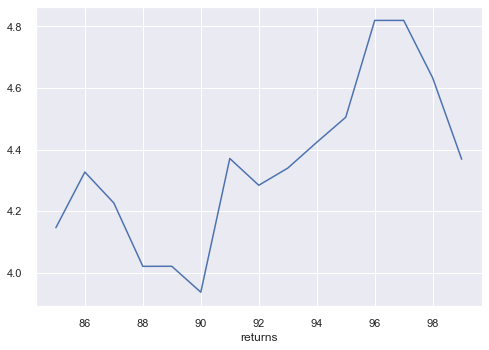

In [121]:
results = tester.results_overview
results.groupby("returns").performance.mean().plot()
plt.show()

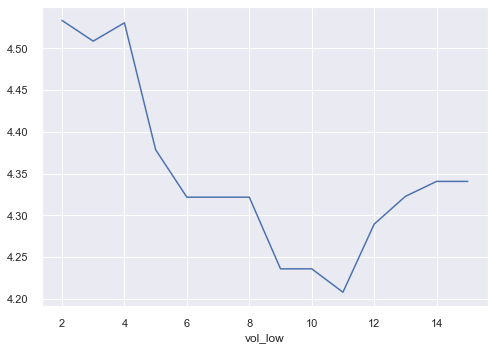

In [122]:
results.groupby("vol_low").performance.mean().plot()
plt.show()

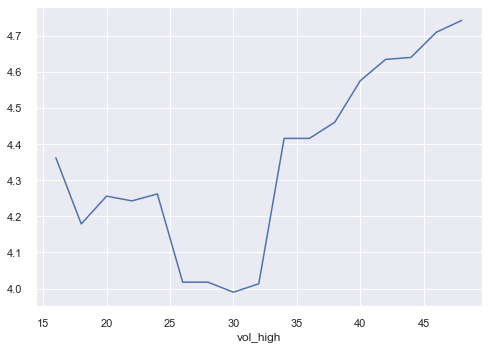

In [123]:
results.groupby("vol_high").performance.mean().plot()
plt.show()

As we see from the plots, it is best to take a 96% log return threshold and (3%, 48%) log volume changes threshold. However, 96th return percentile is a too big value. Therefore, to avoid overfitting, I will choose 94% return percentile

In [124]:
tester.test_strategy((96, 3, 48))

SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTCUSDT | THRESHOLDS = 0.07906, [-0.65398 -0.04928]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         5.703824
Multiple (Buy-and-Hold):     4.368439
--------------------------------------
Out-/Underperformance:       1.335385


CAGR:                        0.701876
Annualized Mean:             0.532176
Annualized Std:              0.822194
Sharpe Ratio:                0.853661


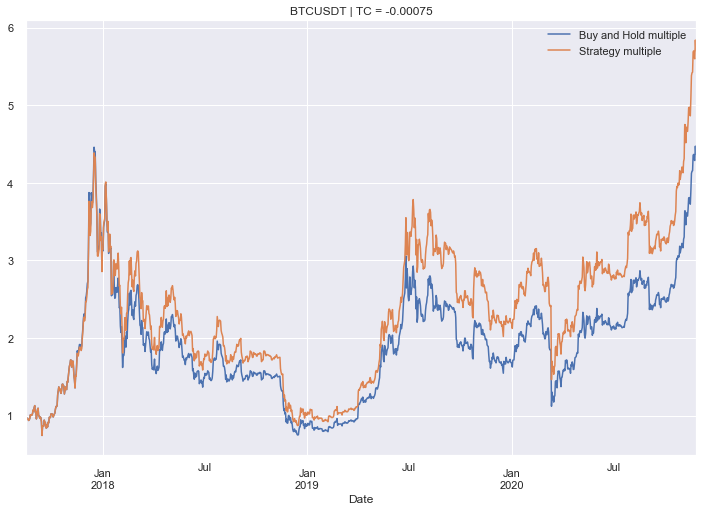

In [125]:
tester.plot_results()

As we see, our strategy outperformed the simple buy and hold, but just a bit. However, let's see if our strategy performs as well at the forward testing

### Forward testing

In [126]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2020-11-26"
end = "2021-12-31"
tc = -0.00075

In [127]:
tester = Long_Only_Backtester(filepath = filepath, symbol = symbol, start = start, end = end, tc = tc)
tester.test_strategy((94, 3, 44))

SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTCUSDT | THRESHOLDS = 0.06961, [-0.63482 -0.05403]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         2.876
Multiple (Buy-and-Hold):     2.694948
--------------------------------------
Out-/Underperformance:       0.181052


CAGR:                        1.623805
Annualized Mean:             0.967037
Annualized Std:              0.794303
Sharpe Ratio:                2.044316


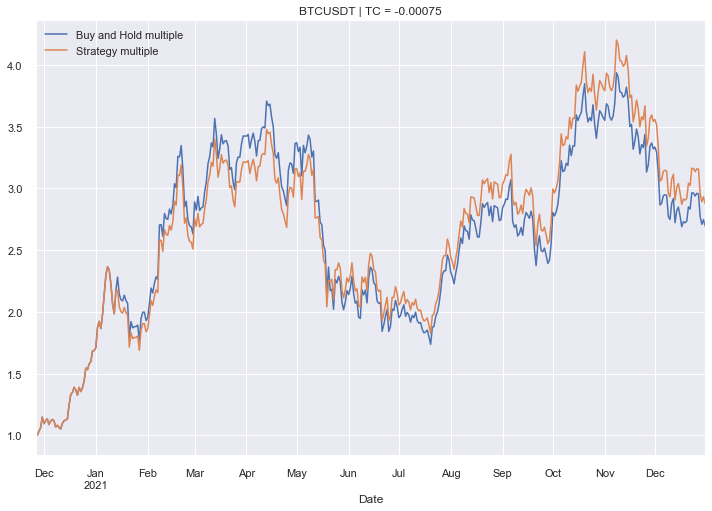

In [128]:
tester.plot_results()

As we see from this plot, our strategy is a still a bit better then the simple buy and hold in the forward test. Therefore, this strategy is somewhat valuable. By valuable I mean that its multiple is greater than the buy and hold multiple. However, the difference is very small. Thus, let's explore other strategies and look if we can achieve a better result

Also, at the end of each forward test, we will take a look how many times we took a long position and a neutral position. This will help to understand whether our strategy makes a difference, because if we almost never take a neutral or short position, then our strategy is not so different from the simple buy and hold. Any number of neutral and short positions, which is greater than 5 is an okay indicator that our strategy indeed is different from the simple buy and hold.

## Position distribution

In [129]:
tester.results.position.value_counts()

1    394
0      7
Name: position, dtype: int64

In this case, we took a neutral position 7 times, which indicates that our strategy is different from the buy and hold.